In [8]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

In [ ]:
!curl -Lo data.zip https://www.kaggle.com/api/v1/datasets/download/jeanmidev/smart-meters-in-london
!mkdir data
!unzip data.zip -d data
!rm data.zip

In [3]:
households = pd.read_csv("data/informations_households.csv")
acorn = pd.read_csv(
    filepath_or_buffer="data/acorn_details.csv",
    encoding="windows-1252",
)
holidays = pd.read_csv(
    filepath_or_buffer="data/uk_bank_holidays.csv",
    parse_dates=["Bank holidays"],
)
daily_weather = pd.read_csv(
    filepath_or_buffer="data/weather_daily_darksky.csv",
    parse_dates=[
        "temperatureMaxTime",
        "temperatureMinTime",
        "apparentTemperatureMinTime",
        "apparentTemperatureHighTime",
        "time",
        "sunsetTime",
        "sunriseTime",
        "temperatureHighTime",
        "uvIndexTime",
        "temperatureLowTime",
        "apparentTemperatureMaxTime",
        "apparentTemperatureLowTime",
    ],
)
hourly_weather = pd.read_csv(
    filepath_or_buffer="data/weather_hourly_darksky.csv",
    parse_dates=["time"],
)

In [4]:
daily_consumption = pd.concat(
    pd.read_csv(filepath_or_buffer=path, parse_dates=["day"])
    for path in glob.glob("data/daily_dataset/daily_dataset/block_*.csv")
)
half_hourly_consumption_long = pd.concat(
    pd.read_csv(
        filepath_or_buffer=path,
        converters={
            "energy(kWh/hh)": lambda x: pd.to_numeric(arg=x.strip(), errors="coerce"),
        },
        parse_dates=["tstp"],
    )
    for path in glob.glob("data/halfhourly_dataset/halfhourly_dataset/block_*.csv")
)
half_hourly_consumption_wide = pd.concat(
    pd.read_csv(filepath_or_buffer=path, parse_dates=["day"])
    for path in glob.glob("data/hhblock_dataset/hhblock_dataset/block_*.csv")
)

## Month vs. avg. monthly consumption

In [5]:
t = daily_consumption.copy()
t["year"] = t["day"].dt.year
t["month"] = t["day"].dt.month
t = t.groupby(["LCLid", "year", "month"])["energy_sum"].sum().reset_index()
t = t.groupby("month")["energy_sum"].mean()
t = t.rename("avg_monthly_consumption")
t.index.name = "month"
t

month
1     371.289164
2     324.102117
3     357.854958
4     282.515420
5     252.123494
6     245.403152
7     248.575938
8     246.498210
9     258.064297
10    298.194840
11    334.795762
12    368.063662
Name: avg_monthly_consumption, dtype: float64

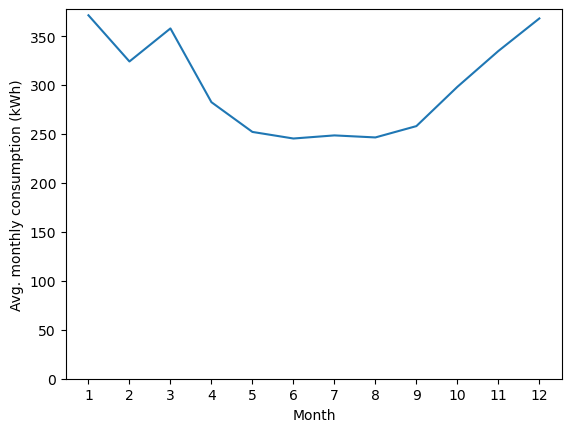

In [6]:
plt.plot(t.index, t.values)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylim(bottom=0)
plt.ylabel("Avg. monthly consumption (kWh)");

## Daily max temp vs. avg. daily consumption (2013)

In [24]:
t = daily_consumption.copy()[daily_consumption["day"].dt.year == 2013]
t["day_of_year"] = t["day"].dt.dayofyear
t = t.groupby("day_of_year")["energy_sum"].mean().reset_index()
r = daily_weather.copy()[daily_weather["temperatureMaxTime"].dt.year == 2013]
r["day_of_year"] = r["temperatureMaxTime"].dt.dayofyear
r = r.filter(["day_of_year", "temperatureMax"])
t = t.merge(right=r, on="day_of_year").set_index("day_of_year")
t.columns = ["avg_daily_consumption", "daily_max_temp"]
t

,avg_daily_consumption,daily_max_temp
day_of_year,,
1,11.839174,7.49
2,12.016655,10.82
3,11.399221,11.41
4,11.417020,10.79
5,11.709836,10.66
...,...,...
361,11.661978,10.99
362,11.379026,7.81
363,11.973593,7.56


In [25]:
a, b, c = np.polyfit(x=t["daily_max_temp"], y=t["avg_daily_consumption"], deg=2)
a, b, c

(0.006321807485330998, -0.42020231234008915, 14.43016472206293)

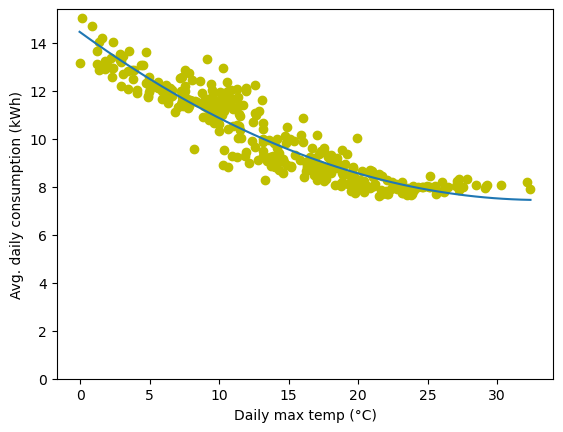

In [26]:
plt.scatter(x=t["daily_max_temp"], y=t["avg_daily_consumption"], color="y")
x = np.linspace(t["daily_max_temp"].min(), t["daily_max_temp"].max())
plt.plot(x, a * x ** 2 + b * x + c)
plt.xlabel("Daily max temp (°C)")
plt.ylim(bottom=0)
plt.ylabel("Avg. daily consumption (kWh)");

In [28]:
metrics.r2_score(
    t["avg_daily_consumption"],
    a * t["daily_max_temp"] ** 2 + b * t["daily_max_temp"] + c,
)

0.8736873691696522

## Hour vs. avg. hourly consumption

In [17]:
t = half_hourly_consumption_long.copy()
t = t[t["energy(kWh/hh)"].notna()]
t["date"] = t["tstp"].dt.date
t["hour"] = t["tstp"].dt.hour
t = t.groupby(["LCLid", "date", "hour"])["energy(kWh/hh)"].sum().reset_index()
t = t.groupby("hour")["energy(kWh/hh)"].mean().rename("avg_hourly_consumption")
t

hour
0     0.347602
1     0.289939
2     0.249546
3     0.231265
4     0.228955
5     0.251458
6     0.314518
7     0.385446
8     0.426915
9     0.431469
10    0.427858
11    0.428273
12    0.432695
13    0.428642
14    0.420943
15    0.432359
16    0.482747
17    0.562428
18    0.624086
19    0.641612
20    0.625569
21    0.587606
22    0.508431
23    0.401510
Name: avg_hourly_consumption, dtype: float64

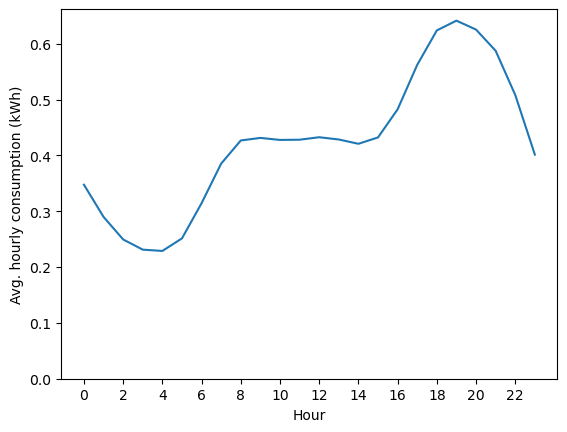

In [22]:
plt.plot(t.index, t.values)
plt.xticks(range(0, 24, 2))
plt.xlabel("Hour")
plt.ylim(bottom=0)
plt.ylabel("Avg. hourly consumption (kWh)");

## Acorn group vs. avg. daily consumption

In [47]:
t = daily_consumption.copy().merge(right=households, on="LCLid")
t = t[t["Acorn"].str.fullmatch("ACORN-[A-Q]")].groupby("Acorn")["energy_sum"]
t = t.mean().rename("avg_daily_consumption")
t.index = t.index.str.replace("ACORN-", "")
t.index.name = "acorn_group"
t

acorn_group
A    19.063876
B    11.902597
C    11.950990
D    13.578131
E    10.353099
F     9.191454
G    10.169360
H    11.007658
I     9.439643
J    11.347921
K    10.006530
L    10.028332
M     9.987455
N     9.218043
O     8.528726
P     6.611038
Q     7.564822
Name: avg_daily_consumption, dtype: float64

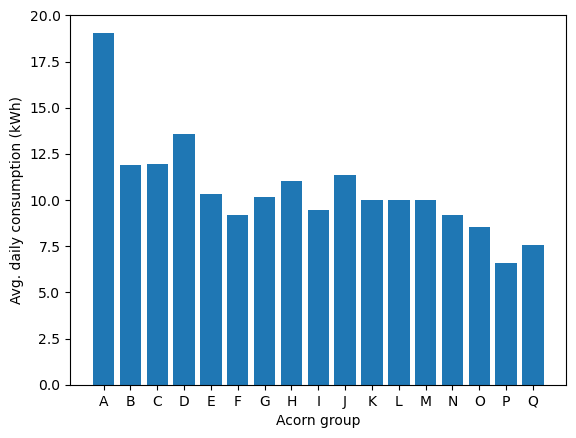

In [48]:
plt.bar(t.index, t.values)
plt.xlabel("Acorn group")
plt.ylabel("Avg. daily consumption (kWh)");